# DATA602 - Midterm
<br>
Scott Ellis (AR33133)
<br>
Philip Appiah (DW76815)

# Overview:
A company has hired us to help identify what indicators there are for when people will leave. We want to build a predictive model that can help predict if a given person is going to leave or not.

# Imports:

In [1]:
# Data Parsing:
import pandas as pd
import numpy as np
import random
import time
import re
import warnings

# Pipeline Processing:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Encoders/Scalers:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler

# General Machine Learning:
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, confusion_matrix

# Classification Models
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Visualizations:
import seaborn as sns
import matplotlib.pyplot as plt

# Options:
sns.set_theme()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
seed = 28980

%matplotlib inline

In [2]:
# Load in data:
employee_df = pd.read_csv('employee_departure_dataset.csv', index_col=0)
employee_df = employee_df.drop(columns=['RecordId']) 
employee_df

,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Dependents,Certifications,OnsiteOpportunities,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left
0,1,>30miles,8,45,1,18,3,10,0,4,99.711052,2,3,18,2,4,1,1,1,1,5,3,1,59K,60K,4.0,5.0,2,0
1,0,~10miles,7,73,5,7,5,19,0,4,84.923010,3,4,15,3,1,1,1,3,7,9,3,7,61K,64K,4.0,4.0,2,0
2,0,<5mile,6,65,1,13,2,7,0,1,82.075062,2,3,11,1,0,1,1,5,8,4,3,1,61K,63K,4.0,4.0,3,0
3,0,~15miles,7,18,4,14,3,3,0,3,90.450602,5,4,3,4,2,1,1,2,3,4,4,5,58K,61K,5.0,5.0,7,0
4,1,~20miles,7,73,5,10,1,18,0,4,99.017646,5,1,17,4,3,0,1,2,5,1,6,3,61K,62K,5.0,5.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,>30miles,6,32,5,13,3,5,1,3,89.265041,1,1,6,0,2,1,1,2,8,8,5,2,56K,57K,4.0,5.0,2,1
299996,1,~15miles,8,25,4,6,5,7,1,5,82.056620,5,1,11,2,0,1,1,2,5,8,3,4,63K,65K,5.0,5.0,2,0
299997,0,~20miles,6,91,4,18,5,1,1,4,98.140028,5,4,9,2,1,0,1,5,7,8,3,6,60K,63K,4.0,5.0,6,0
299998,0,<5mile,8,56,5,3,3,1,0,1,80.858489,5,4,3,1,2,1,0,3,2,4,8,1,61K,63K,5.0,5.0,2,0


# Cleaning/EDA:

Before we can progress, we need to fill in some missing values and clean up some formatting. We'll reformat the Salary column and impute those values with a custom imputer (using Random Forest Classifier) and SimpleImputer.

In [3]:
# Check to see what features we are working with:
print(f'Features:\n{employee_df.columns}\n')

# Check for null values:
print(f'\nNull values:')
employee_df.isna().sum()

Features:
Index(['Gender', 'Distance', 'YearsWorked', 'TrainingHours', 'WorkLifeBalance',
       'NumOfProjects', 'JobInvolvement', 'TeamSize', 'MentorshipReceived',
       'TechSkillLevel', 'AttendanceRate', 'StressLevel', 'PeerFeedbackScore',
       'AnnualLeaveDays', 'Dependents', 'Certifications',
       'OnsiteOpportunities', 'SkillDevelopmentCourses', 'ProjectComplexity',
       'WorkSatisfactionScore', 'JobEngagementScore', 'PhysicalActivityScore',
       'MentalWellbeingScore', 'PreviousSalary', 'Salary', 'SelfReview',
       'SupervisorReview', 'DepartmentCode', 'Left'],
      dtype='object')


Null values:


Gender                       0
Distance                   266
YearsWorked                  0
TrainingHours                0
WorkLifeBalance              0
NumOfProjects                0
JobInvolvement               0
TeamSize                     0
MentorshipReceived           0
TechSkillLevel               0
AttendanceRate               0
StressLevel                  0
PeerFeedbackScore            0
AnnualLeaveDays              0
Dependents                   0
Certifications               0
OnsiteOpportunities          0
SkillDevelopmentCourses      0
ProjectComplexity            0
WorkSatisfactionScore        0
JobEngagementScore           0
PhysicalActivityScore        0
MentalWellbeingScore         0
PreviousSalary               0
Salary                       0
SelfReview                 596
SupervisorReview           577
DepartmentCode               0
Left                         0
dtype: int64

In [4]:
# Check the non-numeric features:
nonnum_df = employee_df.select_dtypes(exclude=[np.number]).copy()
nonnum_df

,Distance,PreviousSalary,Salary
0,>30miles,59K,60K
1,~10miles,61K,64K
2,<5mile,61K,63K
3,~15miles,58K,61K
4,~20miles,61K,62K
...,...,...,...
299995,>30miles,56K,57K
299996,~15miles,63K,65K
299997,~20miles,60K,63K
299998,<5mile,61K,63K


## Salary Formatting:

There are 2 salary-related columns (`Salary` and `PreviousSalary`) that need to be cleaned. First we remove the letter 'K', then we convert both features to integers.

In [5]:
# Identify salary columns:
salary_cols = ['Salary', 'PreviousSalary']


for input_col in salary_cols:
    # Remove 'K' from the Salary columns:
    employee_df[input_col] = nonnum_df[input_col].str.replace('K', '')

    # Convert to int16:
    employee_df[input_col] = employee_df[input_col].astype('int16')

# Output results:
display(employee_df.head(3))
employee_df.info()

,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Dependents,Certifications,OnsiteOpportunities,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left
0,1,>30miles,8,45,1,18,3,10,0,4,99.711052,2,3,18,2,4,1,1,1,1,5,3,1,59,60,4.0,5.0,2,0
1,0,~10miles,7,73,5,7,5,19,0,4,84.923010,3,4,15,3,1,1,1,3,7,9,3,7,61,64,4.0,4.0,2,0
2,0,<5mile,6,65,1,13,2,7,0,1,82.075062,2,3,11,1,0,1,1,5,8,4,3,1,61,63,4.0,4.0,3,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Gender                   300000 non-null  int64  
 1   Distance                 299734 non-null  object 
 2   YearsWorked              300000 non-null  int64  
 3   TrainingHours            300000 non-null  int64  
 4   WorkLifeBalance          300000 non-null  int64  
 5   NumOfProjects            300000 non-null  int64  
 6   JobInvolvement           300000 non-null  int64  
 7   TeamSize                 300000 non-null  int64  
 8   MentorshipReceived       300000 non-null  int64  
 9   TechSkillLevel           300000 non-null  int64  
 10  AttendanceRate           300000 non-null  float64
 11  StressLevel              300000 non-null  int64  
 12  PeerFeedbackScore        300000 non-null  int64  
 13  AnnualLeaveDays          300000 non-null  int64  
 14  Depe

## Imputation:

### Distance:

The `Distance` feature has many missing values; if we encode the existing values and run a Random Forest Classifier, we should get better imputation than using something like SimpleImputer. We coudl use Iterative Imputer instead, but that's an area for future explroation.

In [6]:
# Identify nulls:
null_distances = employee_df['Distance'].isna().sum()
print(f'There are {null_distances:,} N/A entries in the `Distance` column.')

# Check balance of dataset:
employee_df['Distance'].value_counts()

There are 266 N/A entries in the `Distance` column.


~10miles    90144
~15miles    89683
~20miles    59842
>30miles    30208
<5mile      29857
Name: Distance, dtype: int64

In [7]:
class DistanceImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features, distances=['<5mile', '~10miles', '~15miles', '~20miles', '>30miles'], random_state=None):
        self.features = features
        self.distances = distances
        self.random_state = random_state
        self.distance_encoder = OrdinalEncoder(categories=[distances], dtype=int)
        self.distance_mdl = RandomForestClassifier(random_state=random_state)

    def fit(self, X, y=None):
        # Ensure X is a DataFrame for internal processing
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.features + ['Distance'])  # Ensure this matches with the actual data structure
        
        # Shuffle the dataset to ensure randomness
        X_shuffled = X.sample(frac=1, random_state=self.random_state, ignore_index=True)
        
        # Separate rows with and without missing values in 'Distance'
        train_data = X_shuffled[X_shuffled['Distance'].notna()].copy()
        
        # Encode distances for training
        train_data['Distance_encoded'] = self.distance_encoder.fit_transform(train_data[['Distance']])
        
        # Train the RandomForest model on rows with non-missing Distance values
        X_train = train_data[self.features]
        y_train = train_data['Distance_encoded'].ravel()
        self.distance_mdl.fit(X_train, y_train)
        
        return self

    def transform(self, X):
        # Ensure X is a DataFrame for internal processing
        original_columns = X.columns if isinstance(X, pd.DataFrame) else self.features + ['Distance']
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=original_columns)
        
        X_transformed = X.copy()
        
        # Check for missing 'Distance' and predict
        missing = X_transformed['Distance'].isna()
        if missing.any():
            test_data = X_transformed.loc[missing, self.features]
            predictions = self.distance_mdl.predict(test_data).astype(int)
            distances = self.distance_encoder.inverse_transform(predictions.reshape(-1, 1))
            X_transformed.loc[missing, 'Distance'] = distances.ravel()
        
        # Ensure that all original columns are included in the return DataFrame
        return X_transformed[original_columns]

In [8]:
# Distance Encodings and relevant features:
distances=['<5mile', '~10miles', '~15miles', '~20miles', '>30miles']
distance_features = ['YearsWorked', 'WorkLifeBalance', 'AttendanceRate', 'StressLevel',
            'Dependents', 'OnsiteOpportunities', 'WorkSatisfactionScore',
            'JobEngagementScore', 'MentalWellbeingScore', 'DepartmentCode']

# Categorical features:
cat_features = []

# Categorical pipeline:
distance_pipeline = Pipeline([
    ('distance_imputer', DistanceImputer(features=distance_features, random_state=seed)),
    ])

# Numerical features:
num_features = []

# Apply the pipeline to employee_df
employee_df = distance_pipeline.fit_transform(employee_df)
display(employee_df)

,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Dependents,Certifications,OnsiteOpportunities,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left
0,1,>30miles,8,45,1,18,3,10,0,4,99.711052,2,3,18,2,4,1,1,1,1,5,3,1,59,60,4.0,5.0,2,0
1,0,~10miles,7,73,5,7,5,19,0,4,84.923010,3,4,15,3,1,1,1,3,7,9,3,7,61,64,4.0,4.0,2,0
2,0,<5mile,6,65,1,13,2,7,0,1,82.075062,2,3,11,1,0,1,1,5,8,4,3,1,61,63,4.0,4.0,3,0
3,0,~15miles,7,18,4,14,3,3,0,3,90.450602,5,4,3,4,2,1,1,2,3,4,4,5,58,61,5.0,5.0,7,0
4,1,~20miles,7,73,5,10,1,18,0,4,99.017646,5,1,17,4,3,0,1,2,5,1,6,3,61,62,5.0,5.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,>30miles,6,32,5,13,3,5,1,3,89.265041,1,1,6,0,2,1,1,2,8,8,5,2,56,57,4.0,5.0,2,1
299996,1,~15miles,8,25,4,6,5,7,1,5,82.056620,5,1,11,2,0,1,1,2,5,8,3,4,63,65,5.0,5.0,2,0
299997,0,~20miles,6,91,4,18,5,1,1,4,98.140028,5,4,9,2,1,0,1,5,7,8,3,6,60,63,4.0,5.0,6,0
299998,0,<5mile,8,56,5,3,3,1,0,1,80.858489,5,4,3,1,2,1,0,3,2,4,8,1,61,63,5.0,5.0,2,0


### Reviews:

Both the `SelfReview` and `SupervisorReview` features were also missing values, so we can impute those. We could use SimpleImputer to get the mean value, or try using regression to fill in those features.

In [9]:
# Impute missing reviews:
review_imputer_pipeline = ColumnTransformer([
    ('review_imputer', SimpleImputer(strategy='most_frequent'), ['SelfReview', 'SupervisorReview']),
])
employee_df[['SelfReview', 'SupervisorReview']] = review_imputer_pipeline.fit_transform(employee_df)

# VErify missing values imputed:
employee_df.isna().sum()

Gender                     0
Distance                   0
YearsWorked                0
TrainingHours              0
WorkLifeBalance            0
NumOfProjects              0
JobInvolvement             0
TeamSize                   0
MentorshipReceived         0
TechSkillLevel             0
AttendanceRate             0
StressLevel                0
PeerFeedbackScore          0
AnnualLeaveDays            0
Dependents                 0
Certifications             0
OnsiteOpportunities        0
SkillDevelopmentCourses    0
ProjectComplexity          0
WorkSatisfactionScore      0
JobEngagementScore         0
PhysicalActivityScore      0
MentalWellbeingScore       0
PreviousSalary             0
Salary                     0
SelfReview                 0
SupervisorReview           0
DepartmentCode             0
Left                       0
dtype: int64

## EDA Visualizations:

To get a better view of our data, we used a few visualizations. 

- First was a correlation heatmap; this allows us to see if any features have a particularly strong correlation with each other, as well as how they relate to the target (`Left`).
- We then ran heatmaps across our featureset; this helps us see the distribution of our features. This will help us later on with our engineering.
- Finally, we checked to see the distribution of our target. This should tell us whether our dataset is balanced or not, and in what proportion.

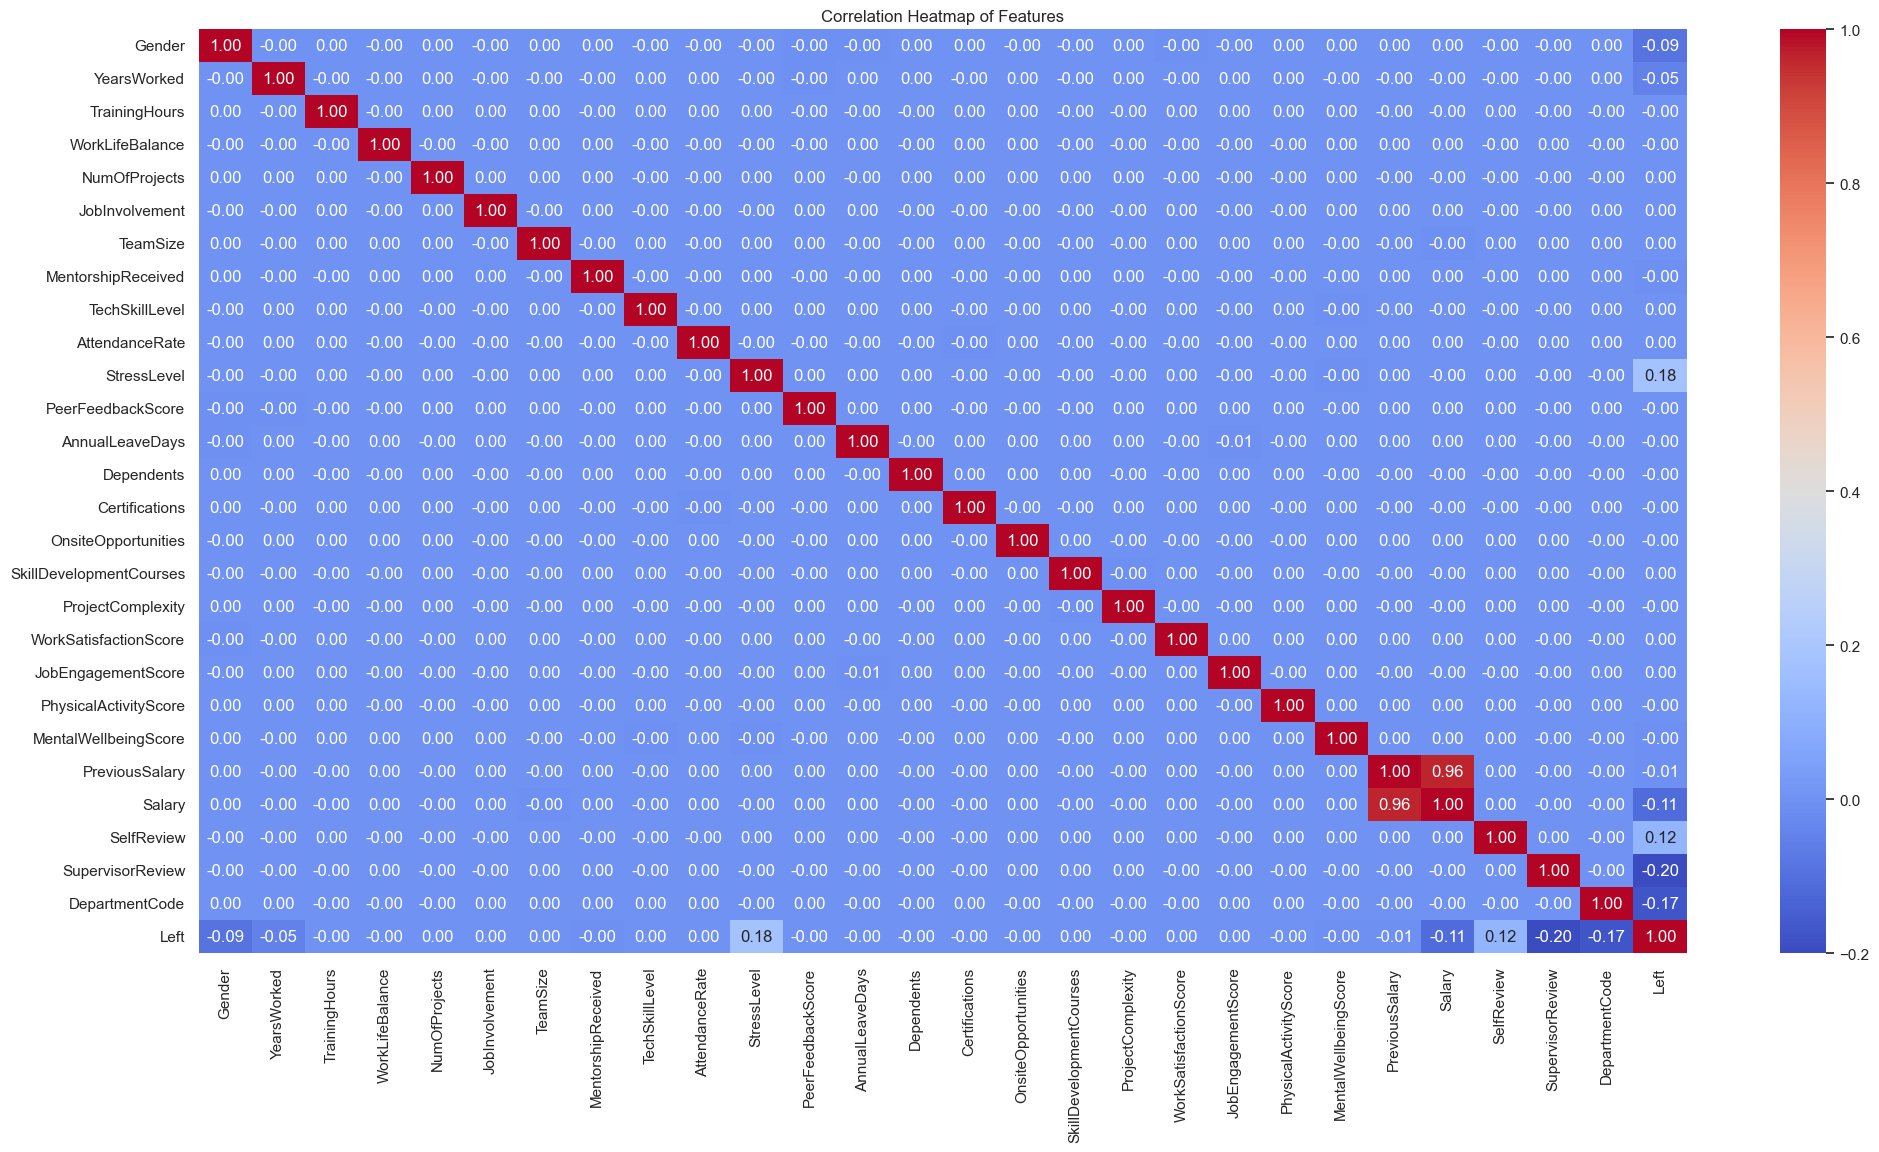

In [10]:
# Correlation heatmap
plt.figure(figsize=(24, 12))
corr = employee_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

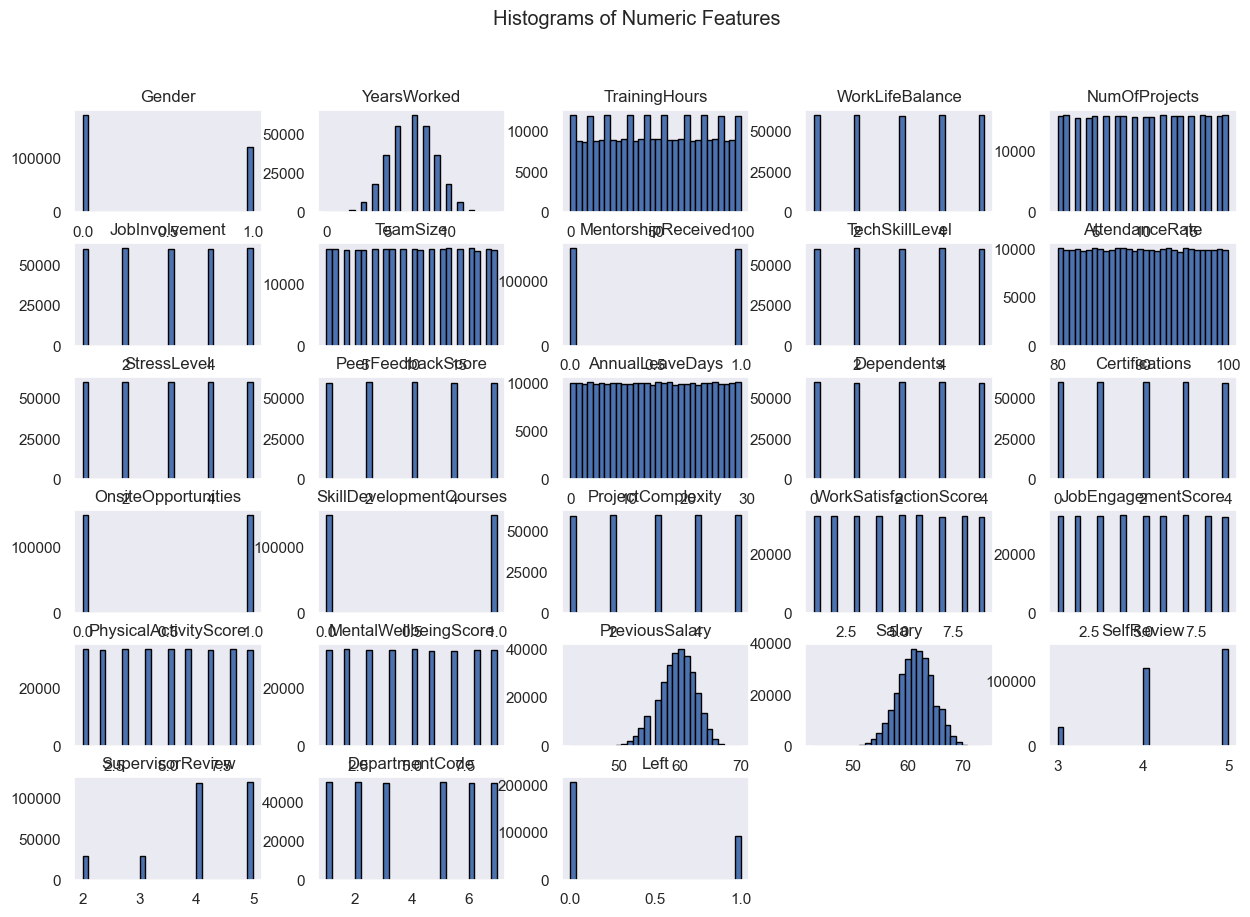

In [11]:
# Histograms for numeric features
employee_df.hist(figsize=(15, 10), bins=30, edgecolor='black', grid=False)
plt.suptitle('Histograms of Numeric Features')
plt.show()

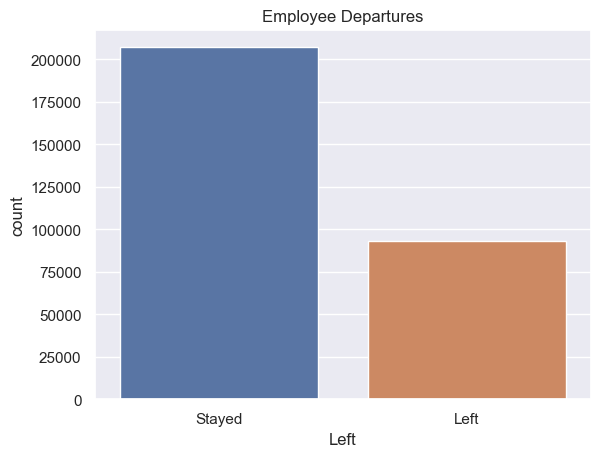

In [12]:
# Count plot for departures
sns.countplot(x='Left', data=employee_df)
plt.title("Employee Departures")
plt.xticks(ticks=[0, 1], labels=['Stayed', 'Left'])
plt.show()

The exploratory data analysis (EDA) of the employee departure dataset focused on data cleaning and preparation for predictive modeling. Key steps included identifying missing values, with 266 entries in the Distance column, and imputing gaps in SelfReview and SupervisorReview using the most frequent values. Salary data was standardized by removing the "K" and converting values to integers. A review of Distance distributions provided insight into commuting patterns, which may relate to turnover. Final checks confirmed that missing values and categorical data are handled appropriately, setting a strong foundation for accurate modeling and retention analysis.

`SelfReview` and `StressLevel` seemed to have the strongest correlations with whether or not an employee left. The `Salary` features and `YearsWorked` all has a normal distribution, which we can use for our engineering. The remaining features had a fairly even distribution. `Salary` and `PreviousSalary` were highely correlated with each other, but most other features lacked much correlation.

# Feature Engineering:

We tried a variety of engineering techniques, as demonstrated below. The most impactful seemed to be the `SalaryGrowth` feature, which reflects a proportion of how much of an increase there was in salary. As we tested different features, we found several that had very little impact on our models; these were commented out, but we kept them in the code to document our strategy.

In [13]:
# Calculate the ratio between self-review scores and supervisor review scores:
employee_df['ReviewRatio'] = employee_df['SelfReview'] / employee_df['SupervisorReview']

# Compute the growth rate of the salary:
employee_df['SalaryGrowth'] = 100*(employee_df['Salary'] - employee_df['PreviousSalary']) / employee_df['PreviousSalary']

# Calculate the average engagement score by combining job engagement and work satisfaction scores:
employee_df['AverageEngagementScore'] = (employee_df['JobEngagementScore'] + employee_df['WorkSatisfactionScore']) / 2

# Assess the engagement per training hour relative to the number of projects:
employee_df['TrainingEngagementScore'] = employee_df['TrainingHours'] / employee_df['NumOfProjects']

# Calculate the ratio of peer feedback score to work satisfaction score:
employee_df['FeedbackToSatisfactionRatio'] = employee_df['PeerFeedbackScore'] / employee_df['WorkSatisfactionScore']

# Derive an overall health score by averaging physical activity and mental wellbeing scores:
employee_df['OverallHealthScore'] = (employee_df['PhysicalActivityScore'] + 
                                     employee_df['MentalWellbeingScore']) / 2

# Calculate the rate of training participation based on hours per project:
employee_df['TrainingParticipationRate'] = employee_df['TrainingHours'] / employee_df['NumOfProjects']

# Combine multiple engagement-related scores to form a comprehensive engagement index:
employee_df['EngagementIndex'] = (employee_df['JobEngagementScore'] + 
                                  employee_df['PeerFeedbackScore'] + 
                                  employee_df['WorkSatisfactionScore']) / 3

# Calculate an interaction term between stress levels and job engagement scores:
employee_df['StressEngagementInteraction'] = employee_df['StressLevel'] * employee_df['JobEngagementScore']

# Determine the leave utilization rate assuming a maximum of 30 annual leave days:
employee_df['LeaveUtilizationRate'] = employee_df['AnnualLeaveDays'] / 30

# Calculate the impact of having dependents relative to the team size:
employee_df['DependentsImpact'] = employee_df['Dependents'] / employee_df['TeamSize']

# Compute a preliminary turnover risk score using a weighted model:
employee_df['TurnoverRisk'] = (employee_df['StressLevel'] * 0.4 + 
                               (5 - employee_df['WorkSatisfactionScore']) * 0.4 + 
                               (5 - employee_df['EngagementIndex']) * 0.2)

# Review the modified dataset:
display(employee_df.head())

,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Dependents,Certifications,OnsiteOpportunities,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left,ReviewRatio,SalaryGrowth,AverageEngagementScore,TrainingEngagementScore,FeedbackToSatisfactionRatio,OverallHealthScore,TrainingParticipationRate,EngagementIndex,StressEngagementInteraction,LeaveUtilizationRate,DependentsImpact,TurnoverRisk
0,1,>30miles,8,45,1,18,3,10,0,4,99.711052,2,3,18,2,4,1,1,1,1,5,3,1,59,60,4.0,5.0,2,0,0.8,1.694915,3.0,2.500000,3.000000,2.0,2.500000,3.000000,10,0.600000,0.200000,2.800000
1,0,~10miles,7,73,5,7,5,19,0,4,84.923010,3,4,15,3,1,1,1,3,7,9,3,7,61,64,4.0,4.0,2,0,1.0,4.918033,8.0,10.428571,0.571429,5.0,10.428571,6.666667,27,0.500000,0.157895,0.066667
2,0,<5mile,6,65,1,13,2,7,0,1,82.075062,2,3,11,1,0,1,1,5,8,4,3,1,61,63,4.0,4.0,3,0,1.0,3.278689,6.0,5.000000,0.375000,2.0,5.000000,5.000000,8,0.366667,0.142857,-0.400000
3,0,~15miles,7,18,4,14,3,3,0,3,90.450602,5,4,3,4,2,1,1,2,3,4,4,5,58,61,5.0,5.0,7,0,1.0,5.172414,3.5,1.285714,1.333333,4.5,1.285714,3.666667,20,0.100000,1.333333,3.066667
4,1,~20miles,7,73,5,10,1,18,0,4,99.017646,5,1,17,4,3,0,1,2,5,1,6,3,61,62,5.0,5.0,5,0,1.0,1.639344,3.0,7.300000,0.200000,4.5,7.300000,2.333333,5,0.566667,0.222222,2.533333


### Below are some feature engineering techniques that we tested, but had very low impact on the final model:

In [14]:
# Identify employees with high project participation:
#employee_df['HighProjectParticipation'] = np.where(employee_df['NumOfProjects'] > 5, 1, 0)

# Create a binary indicator for high stress impact:
#employee_df['StressImpact'] = np.where(employee_df['StressLevel'] >= 4, 1, 0)

# Identify high work-life balance and overall satisfaction based on specific thresholds:
#employee_df['HighWorkLifeBalance'] = np.where(employee_df['WorkLifeBalance'] >= 4, 1, 0)
#employee_df['OverallSatisfaction'] = np.where((employee_df['WorkLifeBalance'] >= 4) & 
#                                              (employee_df['WorkSatisfactionScore'] >= 4), 1, 0)

# Calculate the difference between self-review scores and supervisor review scores:
#employee_df['ReviewDifference'] = employee_df['SelfReview'] - employee_df['SupervisorReview']

# Compute the change in salary, relative to the previous salary:
#employee_df['SalaryChange'] = employee_df['Salary'] - employee_df['PreviousSalary']

# Predictive Modeling:

We start out by setting up a processing pipeline; this will perform our initial imputation, encoding, and scaling. We'll run this on the dataset now, to avoid any additional overhead. To get an idea of which model will perform the best, we will test 10 different models. We'll see how well they do with cross validation, as well. Then we can use a decision tree model to identify feature importances; we can take all of this into account to select a single model for hyperparameter tuning.

The `PreviousSalary`, `Salary`, and `YearsWorked` features all followed a normal distribution, making them good candidates for Standard Scaling. The `AttendanceRate`, `TrainingEngagementScore`, `TrainingParticipationRate`, and `StressEngagementInteraction` features all had a range that was much higher (`>20`) than the remaining features (`0-10`); these were MinMax scaled to fall within the same range as the remaining features. This would preserve their existing distributions while keeping the models from overemphasizing any of them.

### Processing Pipeline:

In [15]:
# Numerical features and their pipelines:
standard_features = ['PreviousSalary', 'Salary', 'YearsWorked',]
minmax_features = ['AttendanceRate', 'TrainingEngagementScore', 'TrainingParticipationRate', 'StressEngagementInteraction',]

# Review imputation:
review_imputer_pipeline = ColumnTransformer([
    ('self_review_imputer', SimpleImputer(strategy='mean'), ['SelfReview']),
    ('supervisor_review_imputer', SimpleImputer(strategy='mean'), ['SupervisorReview'])
], remainder='drop')

# Combine the numerical transformations using ColumnTransformer:
preprocessing_pipeline = ColumnTransformer([
    ('std_scaler', StandardScaler(), standard_features),
    ('minmax_scaler', MinMaxScaler(feature_range=(0, 10)), minmax_features),
    ('review_impute', review_imputer_pipeline, ['SelfReview', 'SupervisorReview']),
    ('ordinal_distances', OrdinalEncoder(categories=[distances]), ['Distance'])
], remainder='passthrough')

# Apply the pipeline to employee_df:
engineered_employees = preprocessing_pipeline.fit_transform(employee_df)

# Define new column names based on the transformations:
additional_cols = ['Distance', 'Gender']
new_columns = standard_features + minmax_features + ['SelfReview', 'SupervisorReview'] + additional_cols\
    + [col for col in employee_df.columns if col not in standard_features + minmax_features + ['SelfReview', 'SupervisorReview'] + additional_cols]

# Create the new DataFrame:
pipeline_df = pd.DataFrame(engineered_employees, columns=new_columns)

# Display the DataFrame to check results:
display(pipeline_df)

,PreviousSalary,Salary,YearsWorked,AttendanceRate,TrainingEngagementScore,TrainingParticipationRate,StressEngagementInteraction,SelfReview,SupervisorReview,Distance,Gender,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,StressLevel,PeerFeedbackScore,AnnualLeaveDays,Dependents,Certifications,OnsiteOpportunities,SkillDevelopmentCourses,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,DepartmentCode,Left,ReviewRatio,SalaryGrowth,AverageEngagementScore,FeedbackToSatisfactionRatio,OverallHealthScore,EngagementIndex,LeaveUtilizationRate,DependentsImpact,TurnoverRisk
0,-0.170741,-0.416015,0.534647,9.855526,0.252525,0.252525,2.045455,4.0,5.0,4.0,1.0,45.0,1.0,18.0,3.0,10.0,0.0,4.0,2.0,3.0,18.0,2.0,4.0,1.0,1.0,1.0,1.0,5.0,3.0,1.0,2.0,0.0,0.80,1.694915,3.0,3.000000,2.0,3.000000,0.600000,0.200000,2.800000
1,0.499176,0.847007,0.000287,2.461477,1.053391,1.053391,5.909091,4.0,4.0,1.0,0.0,73.0,5.0,7.0,5.0,19.0,0.0,4.0,3.0,4.0,15.0,3.0,1.0,1.0,1.0,3.0,7.0,9.0,3.0,7.0,2.0,0.0,1.00,4.918033,8.0,0.571429,5.0,6.666667,0.500000,0.157895,0.066667
2,0.499176,0.531251,-0.534073,1.037497,0.505051,0.505051,1.590909,4.0,4.0,0.0,0.0,65.0,1.0,13.0,2.0,7.0,0.0,1.0,2.0,3.0,11.0,1.0,0.0,1.0,1.0,5.0,8.0,4.0,3.0,1.0,3.0,0.0,1.00,3.278689,6.0,0.375000,2.0,5.000000,0.366667,0.142857,-0.400000
3,-0.505699,-0.100260,0.000287,5.225283,0.129870,0.129870,4.318182,5.0,5.0,2.0,0.0,18.0,4.0,14.0,3.0,3.0,0.0,3.0,5.0,4.0,3.0,4.0,2.0,1.0,1.0,2.0,3.0,4.0,4.0,5.0,7.0,0.0,1.00,5.172414,3.5,1.333333,4.5,3.666667,0.100000,1.333333,3.066667
4,0.499176,0.215496,0.000287,9.508822,0.737374,0.737374,0.909091,5.0,5.0,3.0,1.0,73.0,5.0,10.0,1.0,18.0,0.0,4.0,5.0,1.0,17.0,4.0,3.0,0.0,1.0,2.0,5.0,1.0,6.0,3.0,5.0,0.0,1.00,1.639344,3.0,0.200000,4.5,2.333333,0.566667,0.222222,2.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-1.175615,-1.363282,-0.534073,4.632501,0.248640,0.248640,1.590909,4.0,5.0,4.0,0.0,32.0,5.0,13.0,3.0,5.0,1.0,3.0,1.0,1.0,6.0,0.0,2.0,1.0,1.0,2.0,8.0,8.0,5.0,2.0,2.0,1.0,0.80,1.785714,8.0,0.125000,3.5,5.666667,0.200000,0.000000,-0.933333
299996,1.169093,1.162763,0.534647,1.028276,0.420875,0.420875,8.863636,5.0,5.0,2.0,1.0,25.0,4.0,6.0,5.0,7.0,1.0,5.0,5.0,1.0,11.0,2.0,0.0,1.0,1.0,2.0,5.0,8.0,3.0,4.0,2.0,0.0,1.00,3.174603,6.5,0.200000,3.5,4.666667,0.366667,0.285714,2.066667
299997,0.164218,0.531251,-0.534073,9.070011,0.510662,0.510662,8.863636,4.0,5.0,3.0,0.0,91.0,4.0,18.0,5.0,1.0,1.0,4.0,5.0,4.0,9.0,2.0,1.0,0.0,1.0,5.0,7.0,8.0,3.0,6.0,6.0,0.0,0.80,5.000000,7.5,0.571429,4.5,6.333333,0.300000,2.000000,0.933333
299998,0.499176,0.531251,0.534647,0.429208,1.885522,1.885522,4.318182,5.0,5.0,0.0,0.0,56.0,5.0,3.0,3.0,1.0,0.0,1.0,5.0,4.0,3.0,1.0,2.0,1.0,0.0,3.0,2.0,4.0,8.0,1.0,2.0,0.0,1.00,3.278689,3.0,2.000000,4.5,3.333333,0.100000,1.000000,3.533333


### Downcast DataTypes:

In [16]:
# Downcast all datatypes:
downcast_df = pipeline_df.select_dtypes(include=[np.number]).apply(pd.to_numeric, downcast='signed')
pipeline_df[downcast_df.columns] = downcast_df

# Display DataTypes:
pipeline_df.info(show_counts = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 41 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   PreviousSalary               float64
 1   Salary                       float64
 2   YearsWorked                  float64
 3   AttendanceRate               float64
 4   TrainingEngagementScore      float64
 5   TrainingParticipationRate    float64
 6   StressEngagementInteraction  float64
 7   SelfReview                   int8   
 8   SupervisorReview             int8   
 9   Distance                     int8   
 10  Gender                       int8   
 11  TrainingHours                int8   
 12  WorkLifeBalance              int8   
 13  NumOfProjects                int8   
 14  JobInvolvement               int8   
 15  TeamSize                     int8   
 16  MentorshipReceived           int8   
 17  TechSkillLevel               int8   
 18  StressLevel                  int8   
 19  Pe

### Setup Input Data/Parameters for Modeling:

For our success metric, we've focused on recall. The company wants to use our predictions to keep employees from leaving. We care more about False Negatives, because if someone is going to leave then we want to detect it. It's less of an issue if we misidentify someone who doesn't actually want to leave. We do also check for F1-score, though; optimizing for only recall can lead to some very innacurate models.

In [17]:
# We care more about False Negatives, so we'll focus on recall:
success_metric = 'recall'

# Identify input and output data:
X = pipeline_df.drop(columns=['Left']).copy()
y = pipeline_df[['Left']]

# Execute a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

# Every model can use Numpy arrays, but a couple of them *need* Numpy arrays:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# List of models to test:
modellist = [AdaBoostClassifier(random_state = seed),
             BaggingClassifier(n_jobs=-1, random_state = seed),
             BernoulliNB(),
             DecisionTreeClassifier(random_state = seed),
             GaussianNB(),
             KNeighborsClassifier(),
             LogisticRegression(n_jobs=-1, random_state = seed),
             Perceptron(random_state = seed),
             SVC(max_iter = 100, kernel = 'poly', random_state = seed),
             QuadraticDiscriminantAnalysis(),
            ]

# Check the shape of the training (X) data:
X_train.shape

(240000, 40)

### Train and Evaluate Models:

In [18]:
# DataFrame of model results:
models_df = pd.DataFrame()

# Status message:
print('Progress:\n')

# Loop over each model:
for model in modellist:
    
    # Timekeeping:
    start_time = time.time()

    # String parsing to get the model name (for labeling):
    model_str = str(model).split('(')[0]
    model_name = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', model_str)

    # Fit the model:
    model.fit(X_train, y_train)
    
    # Predict results:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
   
    # Check training and test recall:
    model_training_recall = round(recall_score(y_train, y_train_pred) * 100, 4)
    model_test_recall = round(recall_score(y_test, y_test_pred) * 100, 4)
    model_test_f1 = round(f1_score(y_test, y_test_pred) * 100, 4)


    # Save time:
    model_time = round(time.time() - start_time, 2)
    
    # Convert results to temporary DataFrame:
    temp_df = pd.DataFrame({
                            'Model': [model_name], 
                            'Training Recall Score': [model_training_recall],
                            'Test Recall Score': [model_test_recall],
                            'Test F1 Score': [model_test_f1],
                            'Runtime (s)': [model_time],
                           })
    
    # Add to final DataFrame:
    models_df = pd.concat([models_df, temp_df])

    # Status message:
    status_msg = f'Model: {model_name.ljust(30, " ")}\tRuntime: {model_time:.2f} seconds.'
    print(status_msg)
    
# Display final results:
models_df = models_df.sort_values(by='Test Recall Score', ascending=False, ignore_index=True)
models_df

Progress:

Model: Ada Boost Classifier          	Runtime: 15.14 seconds.
Model: Bagging Classifier            	Runtime: 4.40 seconds.
Model: Bernoulli NB                  	Runtime: 0.27 seconds.
Model: Decision Tree Classifier      	Runtime: 2.89 seconds.
Model: Gaussian NB                   	Runtime: 0.32 seconds.
Model: K Neighbors Classifier        	Runtime: 16.09 seconds.
Model: Logistic Regression           	Runtime: 11.03 seconds.
Model: Perceptron                    	Runtime: 0.49 seconds.
Model: SVC                           	Runtime: 3.89 seconds.
Model: Quadratic Discriminant Analysis	Runtime: 0.44 seconds.


,Model,Training Recall Score,Test Recall Score,Test F1 Score,Runtime (s)
0,Perceptron,99.1486,99.1372,50.5701,0.49
1,SVC,86.9366,86.6433,45.9125,3.89
2,Bagging Classifier,99.4431,81.6069,79.1817,4.40
3,Decision Tree Classifier,100.0000,74.3057,75.0790,2.89
4,Ada Boost Classifier,62.5314,61.9736,68.2037,15.14
5,Logistic Regression,56.4382,55.7994,61.9048,11.03
6,Quadratic Discriminant Analysis,51.2018,50.6875,41.3532,0.44
7,Gaussian NB,50.1244,49.8032,56.4686,0.32
8,K Neighbors Classifier,48.4121,29.6684,37.0094,16.09
9,Bernoulli NB,5.6937,5.8129,10.6338,0.27


In [ ]:
features_df

,Feature,Importance
32,SalaryGrowth,0.213656
30,DepartmentCode,0.138719
18,StressLevel,0.113526
31,ReviewRatio,0.107493
8,Distance,0.076377
2,AttendanceRate,0.026197
10,YearsWorked,0.024169
9,Gender,0.018521
11,TrainingHours,0.018197
39,TurnoverRisk,0.016756


### Cross-Validate Models:

In [19]:
# DataFrame of model results:
crossval_df = pd.DataFrame()

# Number of folds:
k = 10
print(f'{k}-Fold Cross Validation Results:\n')

# Loop over each model:
for model in modellist:
    
    # Timekeeping: 
    start_time = time.time()

    # String parsing to get the model name (for labeling):
    model_str = str(model).split('(')[0]
    model_name = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', model_str)

    # Cross Validation for both Recall and F1-score:
    scores = cross_validate(estimator=model,
                            X=X_test,
                            y=y_test,
                            cv=k,
                            scoring={'recall': 'recall', 'f1': 'f1'},
                            n_jobs=-1,
                            return_train_score=False)
    
    # Average time per fold:
    model_time = (time.time() - start_time) / k

    # Extract and calculate average scores
    avg_recall = round(scores['test_recall'].mean() * 100, 4)
    avg_f1 = round(scores['test_f1'].mean() * 100, 4)
    std_recall = round(scores['test_recall'].std(), 4)
    std_f1 = round(scores['test_f1'].std(), 4)
    
    # Convert results to temporary DataFrame:
    temp_df = pd.DataFrame({
                            'Model': [model_name], 
                            'Average Test Recall': [avg_recall],
                            'Std. Deviation Recall': [std_recall],
                            'Average Test F1-Score': [avg_f1],
                            'Std. Deviation F1-Score': [std_f1],
                            'Runtime (s)': [round(model_time, 2)],
                           })
    
    # Add to final DataFrame:
    crossval_df = pd.concat([crossval_df, temp_df])

    # Status message:
    status_msg = f'Model: {model_name.ljust(30, " ")}\tRuntime: {model_time:.2f} seconds per fold.'
    print(status_msg)

# Display final results sorted by Average Test Recall:
crossval_df = crossval_df.sort_values(by='Average Test Recall', ascending=False, ignore_index=True)
display(crossval_df)

10-Fold Cross Validation Results:

Model: Ada Boost Classifier          	Runtime: 0.43 seconds per fold.
Model: Bagging Classifier            	Runtime: 0.28 seconds per fold.
Model: Bernoulli NB                  	Runtime: 0.10 seconds per fold.
Model: Decision Tree Classifier      	Runtime: 0.12 seconds per fold.
Model: Gaussian NB                   	Runtime: 0.02 seconds per fold.
Model: K Neighbors Classifier        	Runtime: 0.13 seconds per fold.
Model: Logistic Regression           	Runtime: 0.08 seconds per fold.
Model: Perceptron                    	Runtime: 0.03 seconds per fold.
Model: SVC                           	Runtime: 0.12 seconds per fold.
Model: Quadratic Discriminant Analysis	Runtime: 0.03 seconds per fold.


,Model,Average Test Recall,Std. Deviation Recall,Average Test F1-Score,Std. Deviation F1-Score,Runtime (s)
0,Bagging Classifier,81.3858,0.0077,79.0172,0.0071,0.28
1,SVC,77.7497,0.2093,42.8847,0.0721,0.12
2,Decision Tree Classifier,74.1764,0.0060,74.9978,0.0049,0.12
3,Perceptron,71.7605,0.2428,57.1663,0.1450,0.03
4,Ada Boost Classifier,61.1755,0.0116,67.7316,0.0106,0.43
5,Quadratic Discriminant Analysis,60.2297,0.2806,42.6758,0.0802,0.03
6,Logistic Regression,55.7295,0.0130,62.0912,0.0120,0.08
7,Gaussian NB,50.6499,0.0105,57.1055,0.0079,0.02
8,K Neighbors Classifier,26.9559,0.0119,34.0287,0.0124,0.13
9,Bernoulli NB,5.6781,0.0057,10.4085,0.0100,0.10


# Model Selection:

The Support Vector classifier has the best Recall score, so that seemed like the best model. Upon further investigation, the SVC model had a very bad overall performance. Adding in the F1 score shows that the SVC was heavily overclassifying. In light of that, we focused on the next highest recall score; the Bagging Classifier. It perfroms great in terms of recall, but it also has the highest F1 score.

# Identify Feature Importance:

To identify feature importance, we run a simple Decision Tree. This was an iterative process; as we found features with a very low importance, we tested removing them. The Bagging Classifier defaults to using a Decision Tree as it's base model, so any modifications based on Decision Trees should be reflected well.

In [20]:
# Model that has a .feature_importance method:
feature_mdl = DecisionTreeClassifier(random_state=seed)

# Fit the model:
feature_mdl.fit(X_train, y_train)

# Verify accuracy:
y_pred = feature_mdl.predict(X_test)
feature_recall = round(recall_score(y_test, y_pred) * 100, 4)
print(f'Model Recall: {feature_recall:.4f}')

# Check feature importance:
feature_importances = feature_mdl.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
    }).sort_values(by="Importance", ascending=False)

# Display output:
display(features_df)

Model Recall: 74.3057


,Feature,Importance
32,SalaryGrowth,0.213693
30,DepartmentCode,0.138814
18,StressLevel,0.113584
31,ReviewRatio,0.107628
9,Distance,0.076091
3,AttendanceRate,0.026159
2,YearsWorked,0.024598
10,Gender,0.018488
11,TrainingHours,0.018290
39,TurnoverRisk,0.016459


# Hyperparameter Tuning:

We tuned the bagging classifier by modifying it's numerical parameters and it's base model. Since ADA boosting performed moderaly well during the initial model tests, we tested that as a potential base model. We found that using 5 folds tended to result in overtraining, so we increased the cv parameter up to 10.

In [21]:
# Instantiate base models for Bagging:
dt_model = DecisionTreeClassifier(random_state=seed)
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=seed), random_state=seed)

# Set up Bagging Classifier with random state:
best_mdl = BaggingClassifier(random_state=seed, n_jobs=-1)

# Parameter grid testing different base estimators:
param_grid = [{
    'base_estimator': [dt_model, ada_model],
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}]

# Specify scoring metrics for both recall and F1 score
scoring_metrics = {'recall': 'recall', 'f1_score': 'f1'}

# Perform grid search over hyperparameters:
bagging_gc = GridSearchCV(estimator=best_mdl, param_grid=param_grid, cv=10, scoring=scoring_metrics, n_jobs=-1, refit='f1_score', return_train_score=True)
bagging_gcv_results = bagging_gc.fit(X_train, y_train)

# Identify optimal parameters:
opt_bagging_params = bagging_gcv_results.best_params_

# Retrieve best scores from the results
best_index = bagging_gcv_results.best_index_
train_recall = bagging_gcv_results.cv_results_['mean_train_recall'][best_index]
test_recall = bagging_gcv_results.cv_results_['mean_test_recall'][best_index]
train_f1_score = bagging_gcv_results.cv_results_['mean_train_f1_score'][best_index]
test_f1_score = bagging_gcv_results.cv_results_['mean_test_f1_score'][best_index]

# Save scores to DataFrame:
bagging_metrics_df = pd.DataFrame({
    'Model': ['Bagging Classifier CV'], 
    'Train Recall': [train_recall], 
    'Test Recall': [test_recall],
    'Train F1-Score': [train_f1_score], 
    'Test F1-Score': [test_f1_score],
})

# Output parameters and scores:
print(f'Optimal Bagging Classifier Parameters:\n{opt_bagging_params}\n')
display(bagging_metrics_df)

Optimal Bagging Classifier Parameters:
{'base_estimator': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=28980),
                   random_state=28980), 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}



,Model,Train Recall,Test Recall,Train F1-Score,Test F1-Score
0,Bagging Classifier CV,0.999299,0.927231,0.98262,0.83245


The final model performs very well! It does show notable signs of being overfit, but it still outperforms every other model that we've tested. This applies to both the F1 score and recall.

# Visualizations:

### Prediction Confusion Matrix:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     41455
           1       0.76      0.74      0.75     18545

    accuracy                           0.85     60000
   macro avg       0.82      0.82      0.82     60000
weighted avg       0.85      0.85      0.85     60000

[[37072  4383]
 [ 4765 13780]]


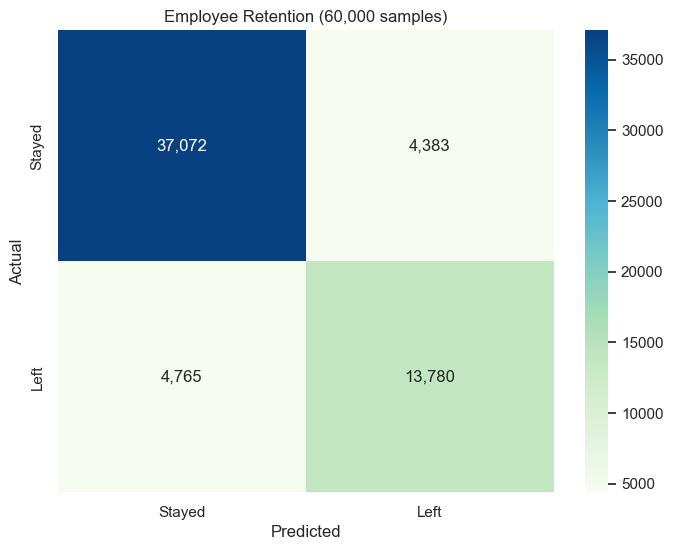

In [22]:
# Evaluation:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Confusion Matrix Visualization:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=',d', cmap='GnBu', xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.title(f'Employee Retention ({len(y_pred):,} samples)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Top 10 Features:

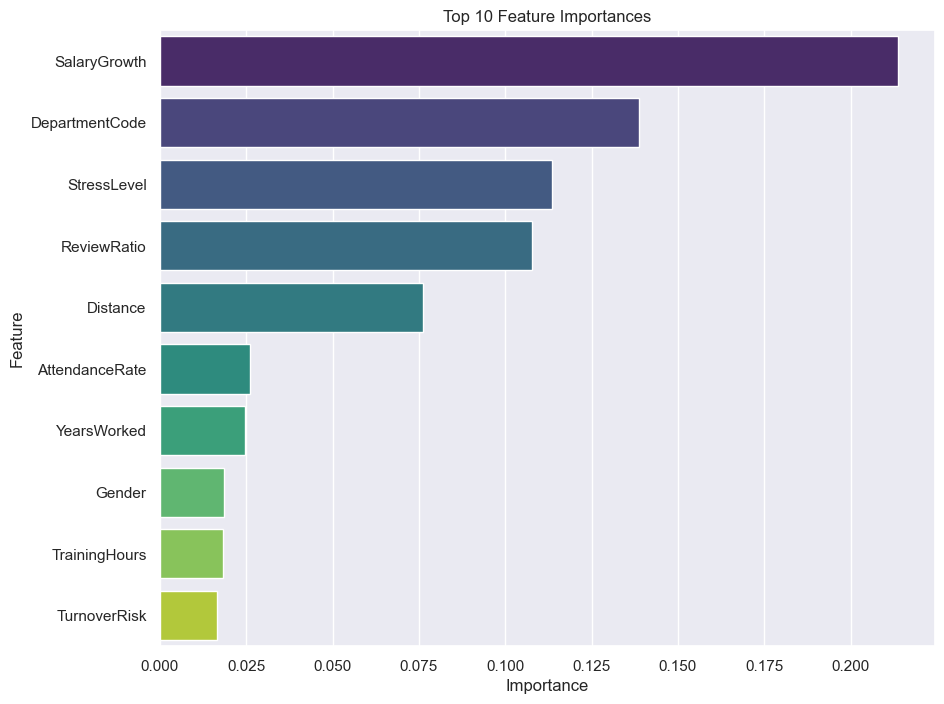

In [23]:
# Select top 10 features:
top_features_df = features_df.head(10)

# Create plot of feature importances:
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='Importance', y='Feature', data=top_features_df, palette='viridis')

# Plot aesthetics:
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

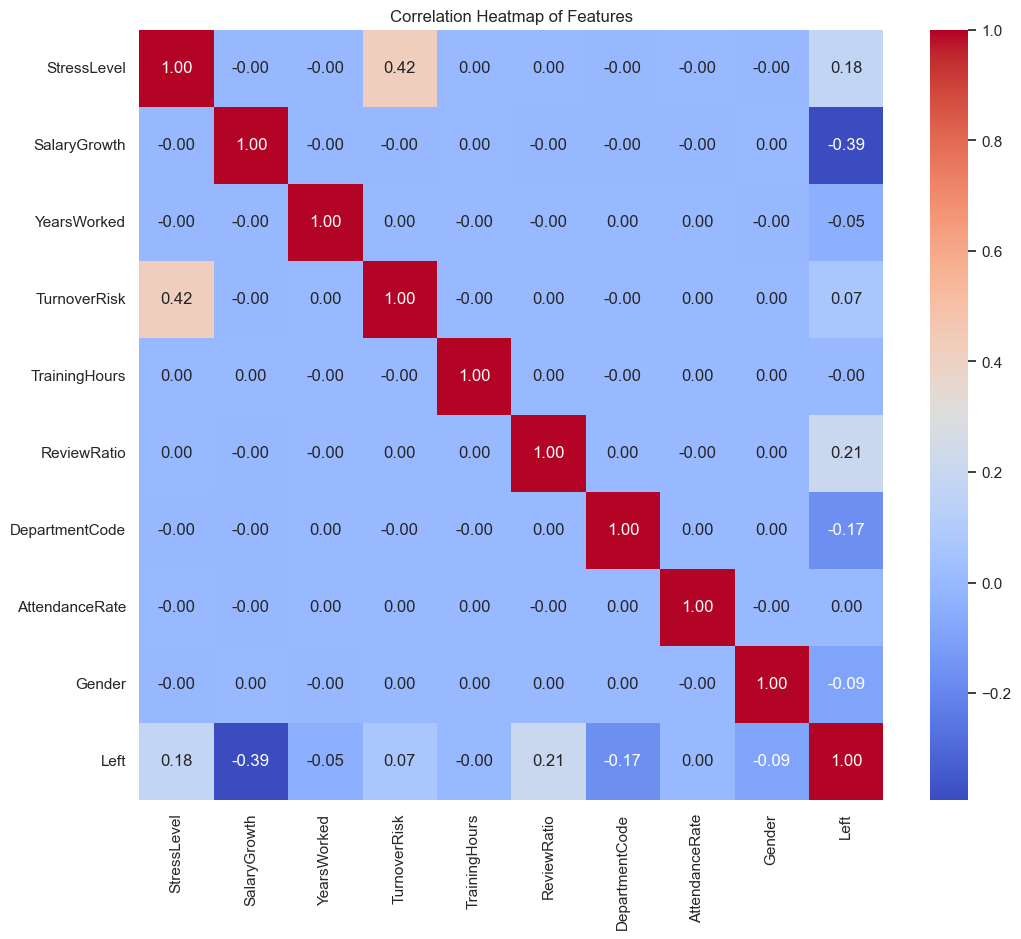

In [24]:
# Identify top features:
correlation_features = list(set(top_features_df['Feature'])) + ['Left']
feature_df = employee_df[correlation_features].copy()

# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = feature_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

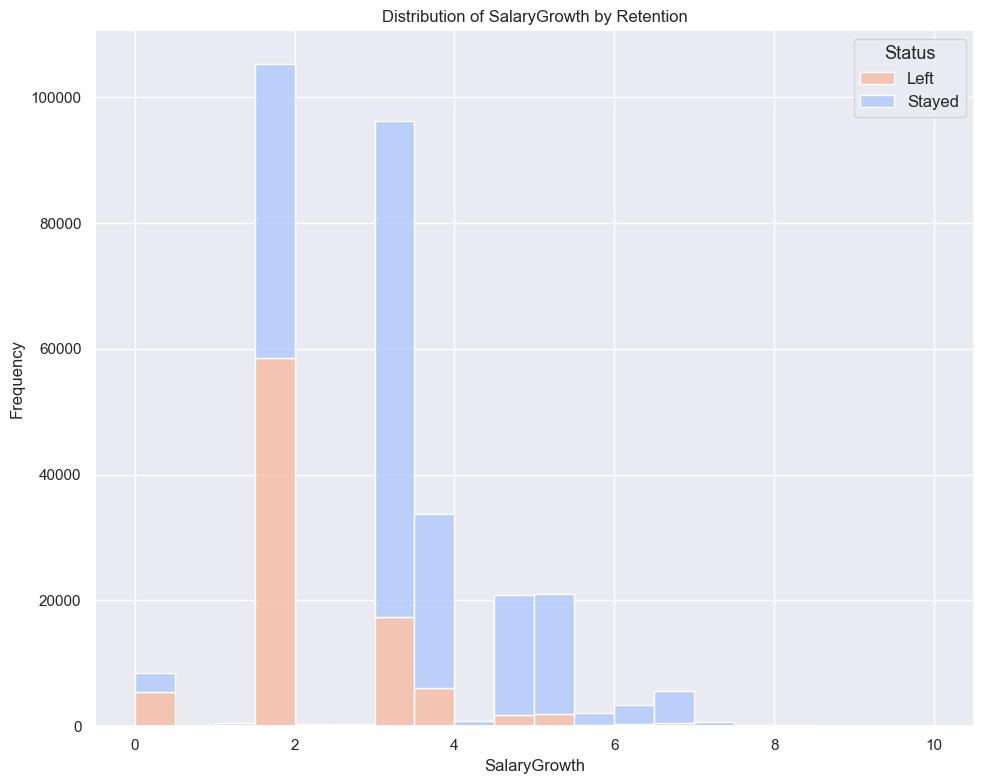

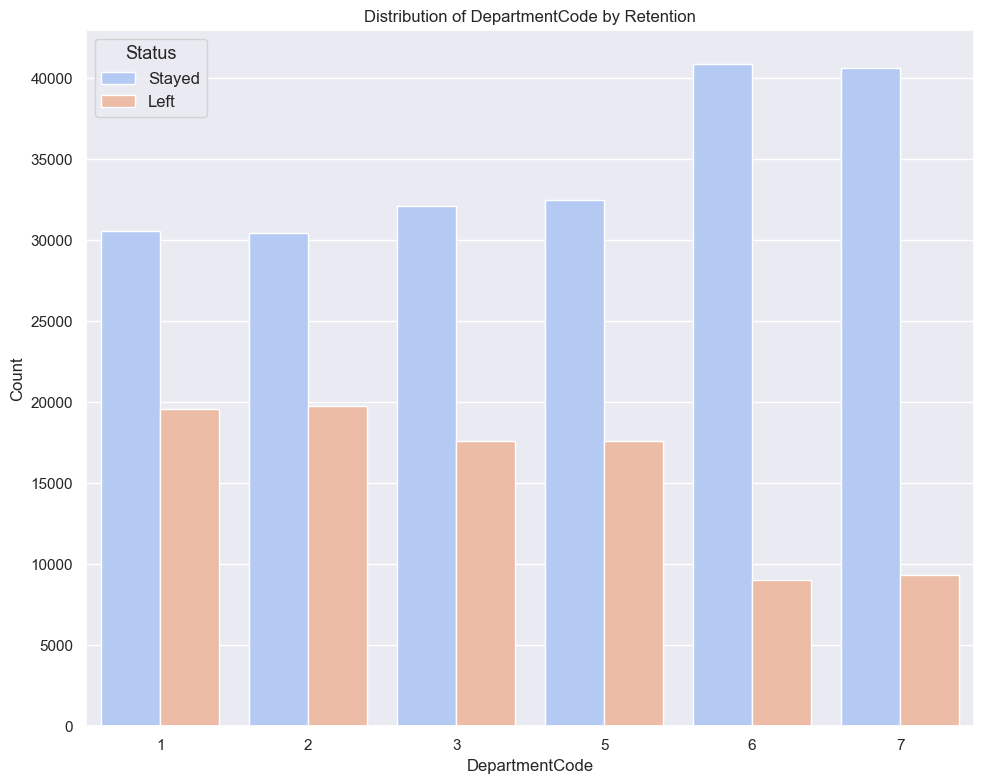

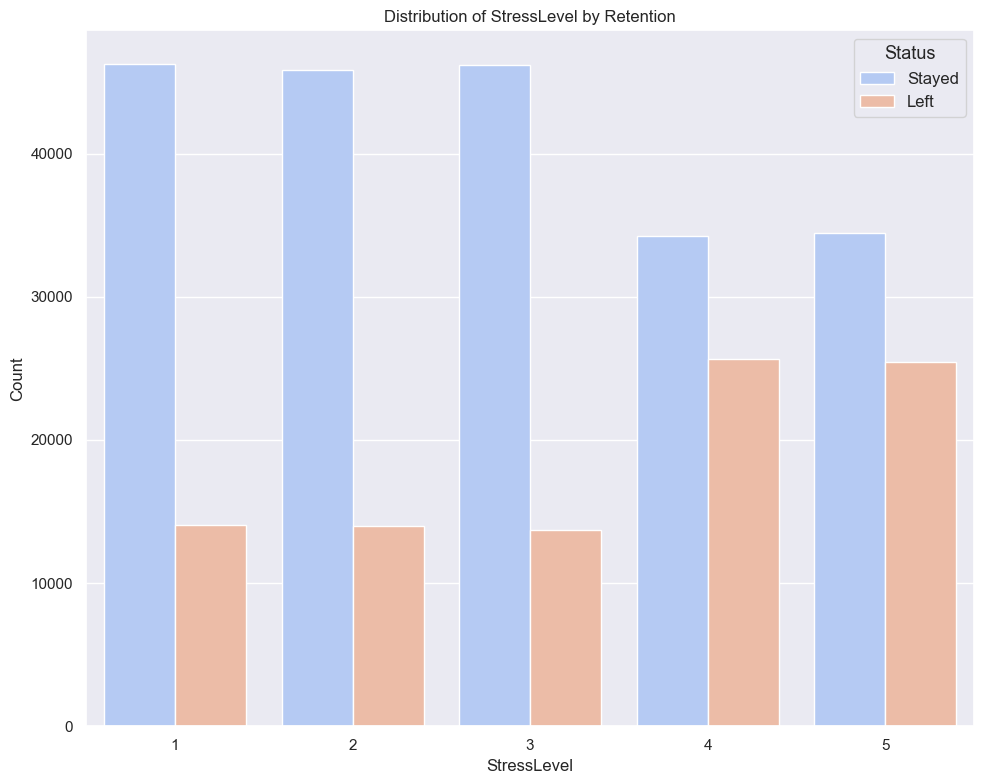

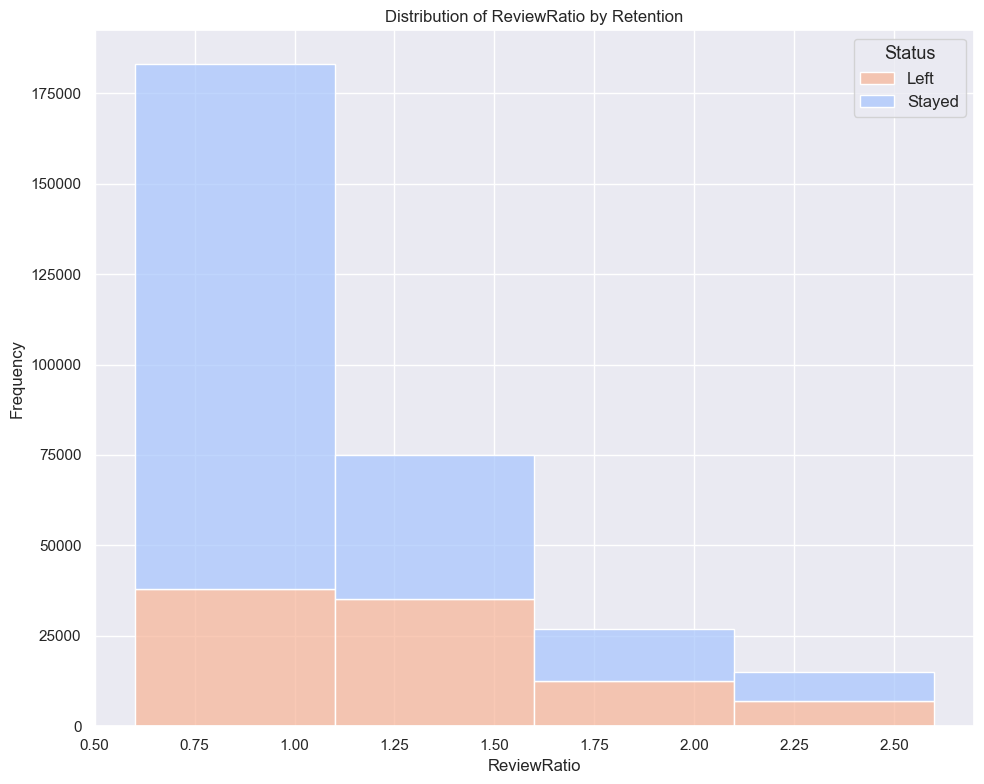

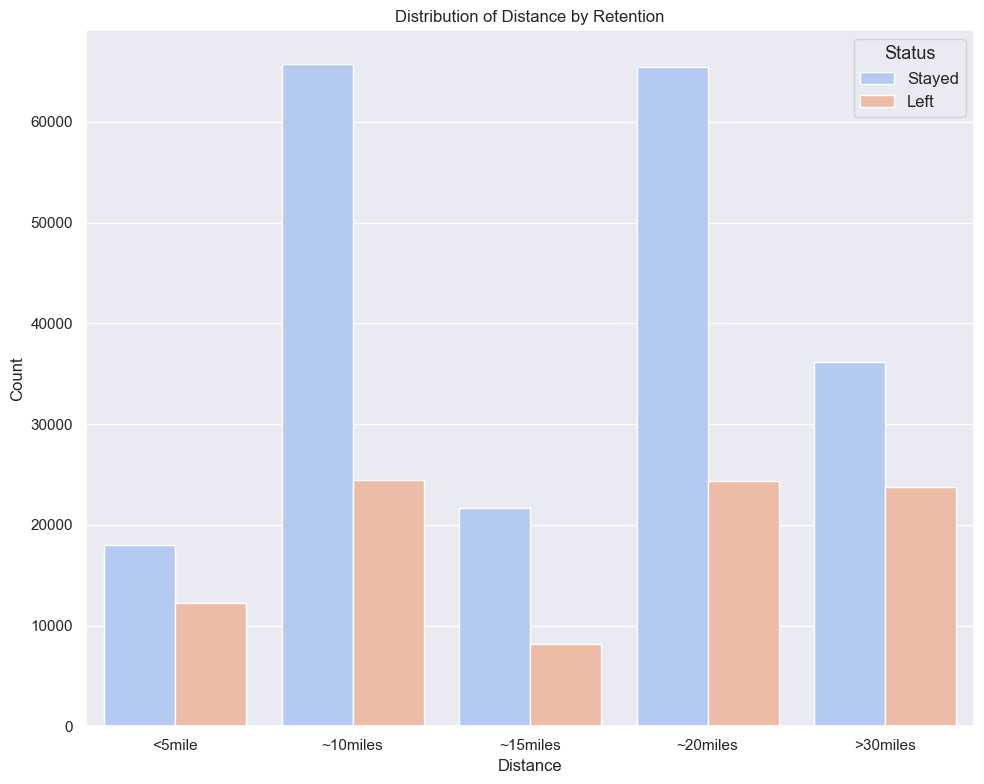

In [25]:
# Extract the top 5 features:
top_5_features = top_features_df['Feature'].head(5)

# Plot aesthetics:
legend_labels = ['Stayed', 'Left']

# Plot each feature against `Left`:
for feature in top_5_features:
    plt.figure(figsize=(10, 8))

    # Categorical data:
    if employee_df[feature].nunique() < 10:
        # Bar plot for categorical data:
        ax = sns.countplot(x=feature, hue='Left', data=employee_df, palette='coolwarm')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, ['Stayed', 'Left'], title='Status', title_fontsize='13', fontsize='12')
        plt.ylabel('Count')

        # Specific handling for the 'Distance' feature
        if feature == 'Distance':
            plt.xlabel('Distance to Workplace')
            ax.set_xticklabels(distances)
        else:
            plt.xlabel(feature)

    else:
        # Continuous data:
        ax = sns.histplot(data=employee_df, x=feature, hue='Left', multiple='stack', palette='coolwarm', binwidth=0.5)
        ax.legend([ 'Left', 'Stayed', ], title='Status', title_fontsize='13', fontsize='12')
        plt.ylabel('Frequency')

    # Update aesthetics:
    plt.title(f'Distribution of {feature} by Retention')
    plt.xlabel(feature)

    # Show the plot:
    plt.tight_layout()
    plt.show()

### Summaries of Feature Importances

The most important features are listed below:
- **`SalaryGrowth`**: Indicates that the growth in an employee's salary is the most significant predictor of whether they will leave the company, suggesting that salary increments play a crucial role in employee retention.
- **`DepartmentCode`**: The department in which an employee works is highly indicative of their likelihood to stay or leave, pointing to varying levels of job satisfaction or work conditions across different departments.
- **`StressLevel`**: High importance of stress levels suggests a direct correlation between an employee's stress at work and their decision to leave, emphasizing the impact of workplace environment on retention.
- **`ReviewRatio`**: This feature likely relates to the balance or ratio of positive to negative reviews an employee receives, which significantly affects their decision to stay or leave.
- **`Gender`**: Suggests some differences in turnover trends between genders, which could point to differing workplace experiences or expectations.
- **`AttendanceRate`**: Regular attendance and its correlation with employee turnover imply that those frequently absent might be at a higher risk of leaving, possibly due to disengagement or external commitments.
- **`YearsWorked`**: The length of time employees have spent at the company influences their likelihood to leave, with longer tenures possibly leading to better retention.
- **`Distance`**: The commuting distance or geographical distance from work is a notable factor, indicating that longer commutes could lead to higher turnover.
- **`TrainingHours`**: The amount of training hours relates to employee development and satisfaction; more training might be linked to increased engagement and reduced turnover.
- **`TurnoverRisk`**: A direct measure or a derived feature indicating the risk of turnover based on various factors, serving as a significant predictor in assessing whether an employee might leave.

# Conclusion:

Our model can predict whether an employee will leave the company (based on historical data) with a high degree of accuracy. We can use what the model knows as a means to identify employees who are more likely to leave.

**Key Findings:**

**Main Factors:** We found that certain things influence whether employees stay or leave. For instance, how much their salary has gone up, their stress at work, and how they rate themselves compared to their bosses are all important. Understanding these factors can help the company keep employees happy.

**Top Model:** We tried out different machine learning models to see which one worked best. At first, one model (called SVC) looked good because it identified many employees who were likely to leave. However, it struggled with identifying those who would stay. On the other hand, the Bagging Classifier performed better overall. It did a good job of spotting those at risk of leaving while keeping false alarms to a minimum.

**Improving Performance:** We took additional steps to make the Bagging Classifier even better by adjusting its settings. This process led to a model that could correctly identify about 92.65% of the employees likely to leave. That means the company could take action in time to help those employees.

**Visual Aids:** We created simple visuals, like a confusion matrix (to show how well our model did) and a chart showing the importance of different factors. These visuals help everyone in the company grasp the results and understand the key reasons behind employee turnover.

Company Takeaways:

By knowing what drives people to leave, the company can enhance strategies like reviewing salaries or improving workplace culture. Regularly checking these factors will help the company adapt to what employees need and changes in the job market. Employees can be internally flagged as being "at risk" for leaving; in this case, preventative steps can be taken.